In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "16"

import numpy as np
import pandas as pd
import sqlalchemy as sa

In [2]:
from dask import dataframe as dd 
from dask import array as da
from dask.diagnostics import ProgressBar # type: ignore

In [3]:
# read h5
embeddings = dd.read_hdf('embeddings.h5', key='embeddings', mode='r', chunksize=1000)

# load 10'000
# embeddings = embeddings.head(10000)

In [4]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.242721,0.416596,-0.247983,-0.269344,-0.045771,0.003983,-0.643093,0.709781,0.536804,-0.393591,...,-0.278954,-0.444132,0.322713,-0.328574,-0.341612,0.522995,-0.866399,0.181326,0.082756,0.199519
1,0.050176,0.300104,0.043600,0.085409,0.293300,0.054499,-0.394082,0.624031,0.046269,-0.905075,...,-0.129070,-0.091093,0.291247,-0.680475,-0.360574,0.428429,-0.698832,0.035107,0.150640,0.537492
2,-0.073493,-0.554840,-0.154205,1.224608,-0.021853,0.167990,-0.546410,0.434660,0.372562,0.506185,...,0.341457,0.355590,0.062959,0.187084,0.297098,0.605960,-0.244980,0.410118,0.038704,0.505363
3,-0.376492,0.100939,0.185906,-0.195942,-0.133067,-0.308304,-0.164811,-0.006943,-0.158194,-0.275358,...,-0.267996,-0.301235,0.391637,0.086361,0.163313,0.592806,0.013871,0.141489,0.321801,-0.102912
4,-0.497712,0.457880,0.340294,0.525480,-0.370195,-0.243208,0.085796,0.192543,-0.146180,-0.187930,...,-0.331745,-0.292625,0.762267,0.540826,-0.029412,0.565210,-0.056860,0.214326,0.237813,0.392732


In [5]:
embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
npartitions=552,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,floa

In [6]:
embeddings.shape

(<dask_expr.expr.Scalar: expr=FromGraph(67978da).size() // 768, dtype=int64>,
 768)

In [7]:
from torch import nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch
device = torch.device("cuda")

In [8]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1  = nn.Linear(768, 512)
        self.linear11 = nn.Linear(512, 512)
        self.linear2  = nn.Linear(512, latent_dims)
        self.linear3  = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear11(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear11 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 768)

    def forward(self, z):
        z = F.elu(self.linear1(z))
        z = F.elu(self.linear11(z))
        z = F.elu(self.linear2(z))
        return z

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
# from torch.utils.data import DataLoader, TensorDataset

# # Convert Dask DataFrame to NumPy array
# embeddings_np = embeddings.compute().values

# # Convert NumPy array to PyTorch tensor
# embeddings_tensor = torch.tensor(embeddings_np, dtype=torch.float32, device=device)

# # Create a TensorDataset
# dataset = TensorDataset(embeddings_tensor)

In [11]:
# embeddings_np.max()

In [12]:
# import tqdm

# x_dim = int(embeddings.shape[1])
# latent_dim = 2
# hidden_dim = 50

# model = VariationalAutoencoder(latent_dim).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# batch_size = 10_000

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# total_batches = len(dataloader)

# model.train()

# for epoch in range(30):
#     overall_loss = 0
#     overall_reconstruction_loss = 0

#     batches = tqdm.tqdm(enumerate(dataloader), total=total_batches)
#     batches.set_description(f"Epoch {epoch + 1}")
#     for batch_idx, (x,) in batches:
#         x = x.to(device)
#         optimizer.zero_grad()

#         x_hat = model(x)
#         loss =  ((x - x_hat)**2).sum() + model.encoder.kl 
        
#         overall_loss += loss.item() / len(x)
#         overall_reconstruction_loss += ((x - x_hat)**2).sum().item() / len(x)
        
#         loss.backward()
#         optimizer.step()

#         batches.set_postfix(loss=overall_loss / (batch_idx + 1))

#     if epoch == 3:
#         optimizer.param_groups[0]['lr'] = 1e-3

#     if epoch == 10:
#         optimizer.param_groups[0]['lr'] = 1e-4

#     if epoch == 20:
#         optimizer.param_groups[0]['lr'] = 1e-6
        
#     print("Epoch", epoch + 1, "Average Loss: ", overall_loss / (batch_size), "Reconstruction Loss: ", overall_reconstruction_loss / (batch_size))

In [13]:
# # Transform all embeddings into the latent space
# with torch.no_grad():
#     embeddings_latent = model.encoder(embeddings_tensor)

# # Convert to numpy array if needed
# embeddings_latent_np = embeddings_latent.cpu().numpy()

# # Print the shape of the new latent embeddings
# print(embeddings_latent_np.shape)

In [14]:
embeddings_size = embeddings.to_dask_array(lengths=True)

In [15]:
# explain memory usage by dask
embeddings_size

dask.array<values, shape=(551657, 768), dtype=float32, chunksize=(1000, 768), chunktype=numpy.ndarray>

In [16]:
from dask_ml.decomposition import PCA

pca = PCA(n_components=100)

embeddings_pca = pca.fit_transform(embeddings_size)

embeddings_pca

dask.array<mul, shape=(551657, 100), dtype=float32, chunksize=(1000, 100), chunktype=numpy.ndarray>

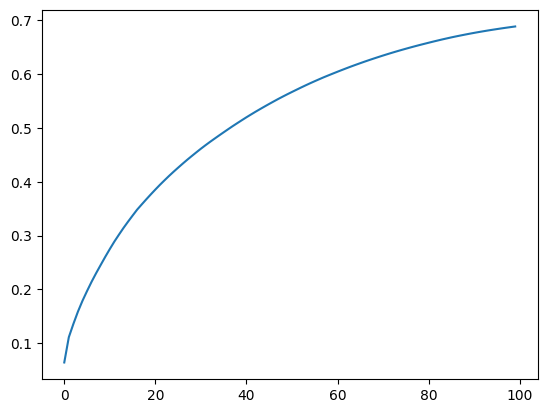

In [17]:
# explain variance
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [18]:
embeddings_pca

dask.array<mul, shape=(551657, 100), dtype=float32, chunksize=(1000, 100), chunktype=numpy.ndarray>

In [19]:
from sklearn.cluster import KMeans

idx = np.random.choice(embeddings_pca.shape[0], 100_000, replace=False)
embeddings_pca_subset = embeddings_pca[idx].compute()

In [20]:
# kmeans = KMeans(
#     n_clusters=150,
#     init='random',
#     n_init=5,   
#     verbose=1,
# )

# kmeans.fit(embeddings_pca_subset)

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def cluster_and_mesure(n_clusters, data):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='random',
    )
    kmeans.fit(data)

    score = silhouette_score(data, kmeans.labels_, sample_size=10_000)

    return score, kmeans


# score, kmeans = cluster_and_mesure(150, embeddings_pca_subset)

# score

In [27]:
scores_models = []

for n_clusters in range(10, 150, 10):
    score, kmeans = cluster_and_mesure(n_clusters, embeddings_pca_subset)
    print(n_clusters, score)
    scores_models.append((n_clusters, score, kmeans))

10 0.043076888
20 0.0398032
30 0.03694467
40 0.045452703
50 0.045166455
60 0.053216796
70 0.05892123
80 0.05997356
90 0.054414283
100 0.0617042
110 0.057860468
120 0.04939539
130 0.052068714
140 0.05607627


In [28]:
for n_clusters in range(150, 300, 10):
    score, kmeans = cluster_and_mesure(n_clusters, embeddings_pca_subset)
    print(n_clusters, score)
    scores_models.append((n_clusters, score, kmeans))

150 0.05627805
160 0.049670197
170 0.052372284
180 0.05486918
190 0.057655316
200 0.05394572
210 0.053572193
220 0.051727924
230 0.056768816
240 0.053454272
250 0.05246482
260 0.05542121
270 0.050590985
280 0.057370506
290 0.05156309


In [29]:
scores_models

[(10, np.float32(0.043076888), KMeans(init='random', n_clusters=10)),
 (20, np.float32(0.0398032), KMeans(init='random', n_clusters=20)),
 (30, np.float32(0.03694467), KMeans(init='random', n_clusters=30)),
 (40, np.float32(0.045452703), KMeans(init='random', n_clusters=40)),
 (50, np.float32(0.045166455), KMeans(init='random', n_clusters=50)),
 (60, np.float32(0.053216796), KMeans(init='random', n_clusters=60)),
 (70, np.float32(0.05892123), KMeans(init='random', n_clusters=70)),
 (80, np.float32(0.05997356), KMeans(init='random', n_clusters=80)),
 (90, np.float32(0.054414283), KMeans(init='random', n_clusters=90)),
 (100, np.float32(0.0617042), KMeans(init='random', n_clusters=100)),
 (110, np.float32(0.057860468), KMeans(init='random', n_clusters=110)),
 (120, np.float32(0.04939539), KMeans(init='random', n_clusters=120)),
 (130, np.float32(0.052068714), KMeans(init='random', n_clusters=130)),
 (140, np.float32(0.05607627), KMeans(init='random', n_clusters=140)),
 (150, np.float32(0

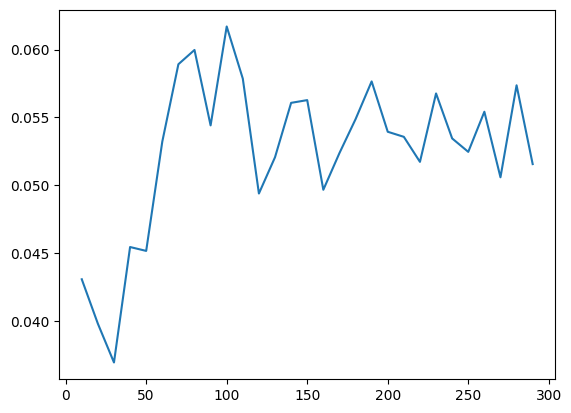

In [30]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in scores_models], [x[1] for x in scores_models])

In [31]:
# run 50-120 clusters with bigger sample size
idx = np.random.choice(embeddings_pca.shape[0], 200_000, replace=False)
embeddings_pca_subset = embeddings_pca[idx].compute()

def cluster_and_mesure(n_clusters, data):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='random',
    )
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_, sample_size=25_000)
    return score, kmeans


scores_models_2 = []

for n_clusters in range(75, 120, 5):
    score, kmeans = cluster_and_mesure(n_clusters, embeddings_pca_subset)
    print(n_clusters, score)
    scores_models_2.append((n_clusters, score, kmeans))

scores_models_2

75 0.05654123
80 0.056156367
85 0.058371086
90 0.055212125
95 0.057826772
100 0.058710136
105 0.050500162
110 0.062874645
115 0.057222765


[(75, np.float32(0.05654123), KMeans(init='random', n_clusters=75)),
 (80, np.float32(0.056156367), KMeans(init='random', n_clusters=80)),
 (85, np.float32(0.058371086), KMeans(init='random', n_clusters=85)),
 (90, np.float32(0.055212125), KMeans(init='random', n_clusters=90)),
 (95, np.float32(0.057826772), KMeans(init='random', n_clusters=95)),
 (100, np.float32(0.058710136), KMeans(init='random', n_clusters=100)),
 (105, np.float32(0.050500162), KMeans(init='random', n_clusters=105)),
 (110, np.float32(0.062874645), KMeans(init='random', n_clusters=110)),
 (115, np.float32(0.057222765), KMeans(init='random', n_clusters=115))]

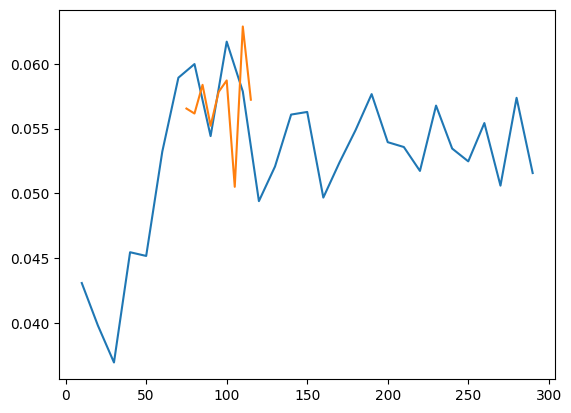

In [32]:
# plot all
plt.plot([x[0] for x in scores_models], [x[1] for x in scores_models])
plt.plot([x[0] for x in scores_models_2], [x[1] for x in scores_models_2])

In [35]:
# best clustering is
best_n_clusters = scores_models_2[np.argmax([x[1] for x in scores_models_2])][0]
best_n_clusters

110

In [36]:
# rerun on whole dataset
embeddings_pca_subset = embeddings_pca.compute()

score, kmeans = cluster_and_mesure(best_n_clusters, embeddings_pca_subset)

In [37]:
score

np.float32(0.059783805)

In [47]:
# show clusitering
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

idxs = np.random.choice(embeddings_pca_subset.shape[0], 100_000, replace=False)

latent = tsne.fit_transform(embeddings_pca_subset[idxs])

c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.010s...
[t-SNE] Computed neighbors for 100000 samples in 5.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

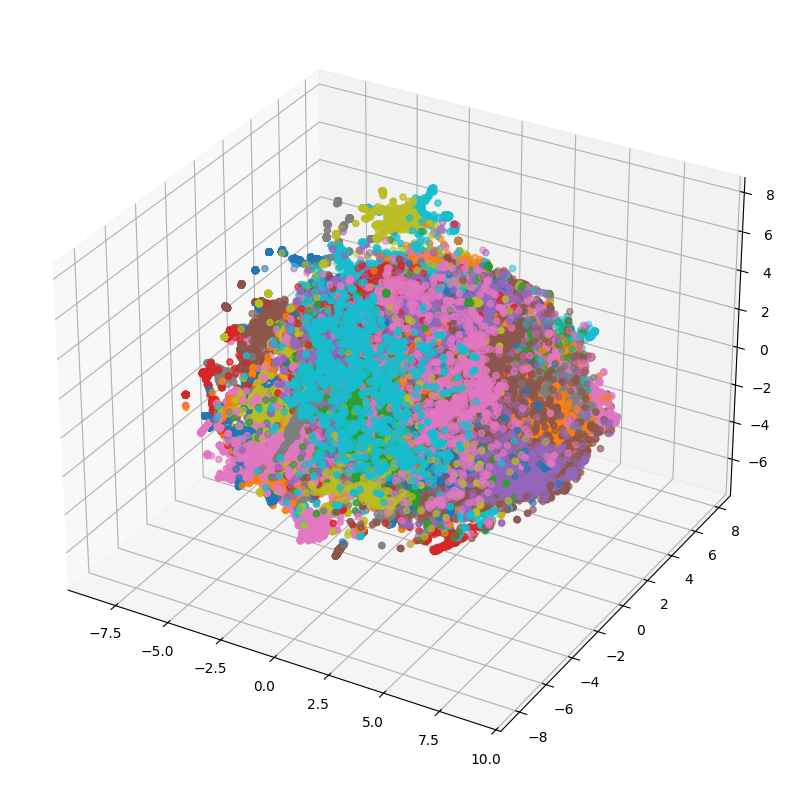

In [52]:
# plot clusters (3D)
plt.figure(figsize=(10, 10))

# 3d scatter
ax = plt.axes(projection='3d')

for i in range(best_n_clusters):
    idx = kmeans.labels_ == i
    # limit to 100_000
    idx = idx[idxs]
    ax.scatter(latent[idx, 0], latent[idx, 1], latent[idx, 2], label=f'Cluster {i}')

plt.show()

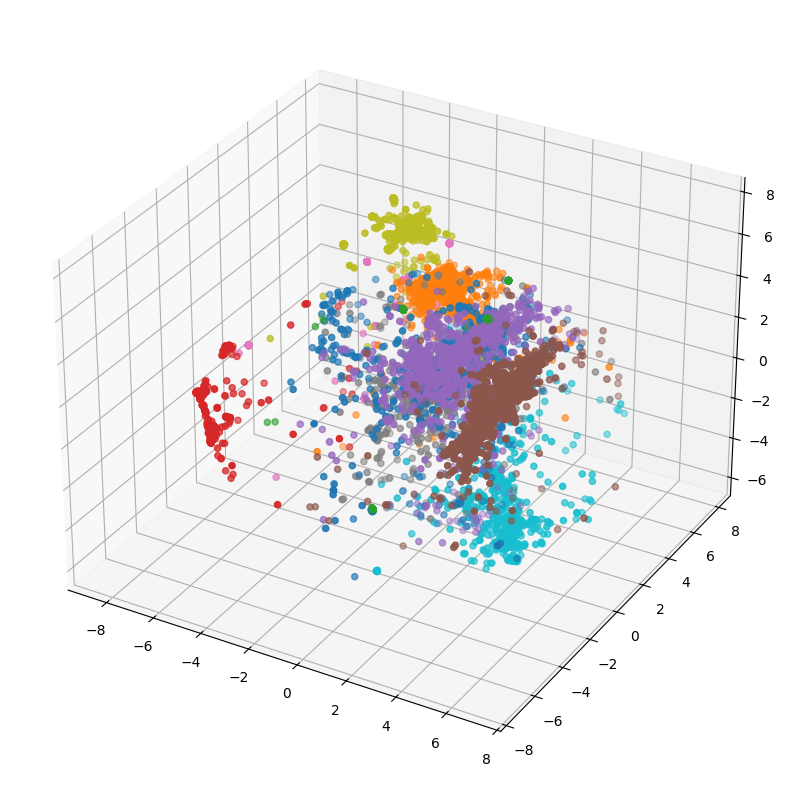

In [64]:
# show only few clusters
plt.figure(figsize=(10, 10))

# 3d scatter
ax = plt.axes(projection='3d')

for i in range(10):
    idx = kmeans.labels_ == i
    # limit to 100_000
    idx = idx[idxs]
    ax.scatter(latent[idx, 0], latent[idx, 1], latent[idx, 2], label=f'Cluster {i}')

plt.show()

In [58]:
# save as tnse
latent_space_df = pd.DataFrame(latent)
latent_space_df.to_hdf('latent_space_tnse.h5', key='embeddings_3', mode='w')

In [60]:
cluster_labels = kmeans.labels_
cluster_labels

array([20, 20, 93, ..., 93, 93, 77], dtype=int32)

In [61]:
# debug clustering results
kmeans.cluster_centers_.shape

(110, 100)

In [62]:
kmeans.cluster_centers_[0]

array([ 2.43415904e+00, -1.49380088e+00,  1.84450984e+00,  2.10699582e+00,
        5.11335373e-01, -3.34701538e-01,  8.77697587e-01, -1.83855689e+00,
        4.60971594e-01, -1.50131226e+00, -1.16944230e+00, -6.52983844e-01,
        9.35237765e-01, -1.22763231e-01, -4.17426735e-01,  4.68233705e-01,
       -7.83282220e-01,  6.75617993e-01,  1.40207082e-01, -6.05836928e-01,
       -2.46071160e-01,  9.78746474e-01,  7.11668193e-01, -8.67403686e-01,
        6.71643019e-02,  7.19827890e-01,  5.54226816e-01, -5.46527743e-01,
        4.00510043e-01, -6.21354461e-01, -4.90959197e-01, -6.35015666e-01,
        2.61689305e-01, -3.10171209e-03,  5.14209747e-01, -4.41959351e-01,
        2.52127260e-01, -1.49428830e-01, -3.14793736e-02, -4.82481457e-02,
        4.16811258e-01, -3.75594139e-01, -3.50503713e-01,  5.25723845e-02,
        8.72329921e-02,  1.21750176e-01, -4.44454610e-01,  3.04280724e-02,
        2.74659604e-01,  6.08101860e-02, -2.16185644e-01, -2.84802228e-01,
       -2.42903940e-02, -

In [63]:
# save clusters
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_hdf('clusters_tnse.h5', key='clusters', mode='w', format='table')

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.decomposition import IncrementalPCA

# isomap = Isomap(n_components=2, n_neighbors=15, p=2)
# lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
pca = IncrementalPCA(n_components=2)

transformed_embeddings = pca.fit_transform(embeddings_latent_np)

In [ ]:
transformed_embeddings.shape

(551657, 2)

In [ ]:
# error of the embedding
pca.explained_variance_ratio_

array([0.54784457, 0.45215543])

In [ ]:
embeddings_latent_np.shape

(551657, 2)

In [ ]:
transformed_embeddings.shape

(551657, 2)

In [ ]:
embeddings_latent_np[:10]

array([[-0.8570561 ,  0.39298123],
       [-0.9412669 ,  0.38953438],
       [-0.9458833 ,  0.18851502],
       [-0.7798315 , -0.04957933],
       [-0.83251005,  0.37905842],
       [-0.63226056,  0.46107277],
       [-0.83098745,  0.4566638 ],
       [-0.6298559 ,  0.2940662 ],
       [-0.8801602 ,  0.19601914],
       [-1.1815792 ,  0.14554295]], dtype=float32)

In [ ]:
# save
transformed_embeddings = pd.DataFrame(embeddings_latent_np)
transformed_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

In [ ]:
transformed_embeddings

,0,1
0,-0.857056,0.392981
1,-0.941267,0.389534
2,-0.945883,0.188515
3,-0.779832,-0.049579
4,-0.832510,0.379058
...,...,...
551652,-0.779755,-0.966252
551653,-0.923247,0.600915
551654,-0.826822,0.320256
551655,-0.954018,0.547257


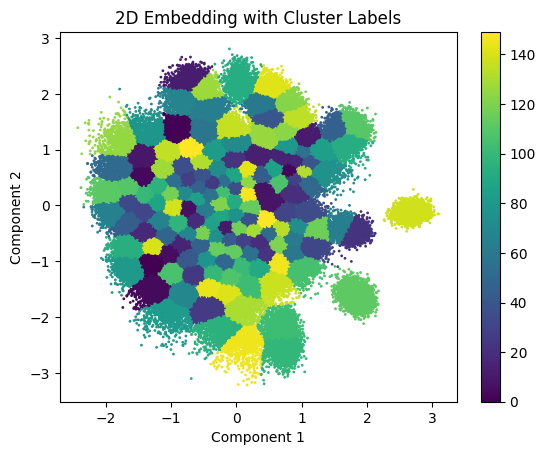

In [ ]:
# plot
import matplotlib.pyplot as plt


plt.scatter(transformed_embeddings[0], transformed_embeddings[1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Embedding with Cluster Labels')
plt.show()

In [ ]:
# save to h5
tsne_embeddings = pd.DataFrame(transformed_embeddings)
tsne_embeddings.to_hdf('tsne_embeddings_2.h5', key='tsne_embeddings', mode='w', format='table')

In [ ]:
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_hdf('clusters_2.h5', key='clusters', mode='w', format='table')